In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:70% !important; }</style>"))

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from joblib import load
from scipy.stats import uniform as sp_uniform
from matplotlib import rc, font_manager

font_path = "/Library/Fonts/NanumGothic.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
fontprop = font_manager.FontProperties(fname=font_path, size=14)

from lightgbm import early_stopping, log_evaluation

from ml_classifiers import Classifiers

# Load Dataset
- breast_cancer 데이터 적용 예시 (Binary classification)

In [2]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
df_breast_cancer = pd.DataFrame(
    breast_cancer["data"], columns=breast_cancer["feature_names"]
)
df_breast_cancer["label"] = breast_cancer["target"]
df_breast_cancer["label"].value_counts(normalize=True)

1    0.627417
0    0.372583
Name: label, dtype: float64

In [3]:
X_train = df_breast_cancer.iloc[:, :-1]
y_train = df_breast_cancer.iloc[:, -1]
feature_names = X_train.columns

# Cross Validation
- 교차 검증 성능을 확인해 봅니다.
- Feature Scaler(`StandardScaler`, `MinMaxScaler`, `RobustScaler`, `MaxAbsScaler`, `Normalizer`)를 지정할 수 있습니다.
    - 만약 이 외에 다른 표준화 방법을 적용하려면 데이터에 이미 적용이 되어 있음을 가정합니다.

In [4]:
clf = Classifiers(feature_scaler="RobustScaler")

In [5]:
# 모듈에 선언되어 있는 알고리즘을 확인해 봅니다. 이 외에 추가할 알고리즘이 있다면 모듈을 수정하여 사용할 수 있습니다.
list(clf._get_classifier_models())

['MLPClassifier',
 'KNeighborsClassifier',
 'SVC',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'ExtraTreesClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GaussianNB',
 'QuadraticDiscriminantAnalysis',
 'GradientBoostingClassifier',
 'LogisticRegression',
 'XGBClassifier',
 'LGBMClassifier']

In [6]:
# 모델별 파라미터를 지정할 수 있습니다.
estimators = [
    "DecisionTreeClassifier",
    "RandomForestClassifier",
    "XGBClassifier",
    "LGBMClassifier",
]

estimator_params = {
    "DecisionTreeClassifier": {
        "criterion": "entropy",
        "splitter": "random",
        "max_depth": 100,
        "min_samples_split": 3,
        "min_samples_leaf": 3,
        "max_features": "sqrt",
    },
    "RandomForestClassifier": {
        "n_estimators": 100,
        "criterion": "entropy",
        "max_depth": 10,
        "min_samples_split": 3,
        "min_samples_leaf": 3,
        "max_features": "sqrt",
        "bootstrap": True,
    },
}

In [7]:
# 교차 검증 실행
clf.run_cross_validation(
    X=X_train,
    y=y_train,
    estimators=estimators,  # 분류 알고리즘 (`estimators="all"`로 하면 해당 모듈에 선언된 모든 알고리즘을 사용하여 예측을 실행합니다.)
    estimator_params=estimator_params,  # 알고리즘별 파라미터 (만약 사용하지 않는다면 디폴트 파라미터로 예측을 수행합니다.)
    scoring=["accuracy", "recall", "precision", "f1", "roc_auc"],  # 모델 성능 지표
    kfold="RepeatedStratifiedKFold",  # Train, Test Split 방법 (클래스 불균형이 크다면 `Stratified`가 좋습니다.)
    n_splits=5,  # K-Fold의 K (일반적으로 3, 5, 10을 많이 사용합니다.)
    n_repeats=5,  # 교차 검증 반복 횟수 (기본값은 10입니다만, 5로 해도 충분한 것 같습니다. 단, `RepeatedStratifiedKFold`와 `RepeatedKFold`에 한해서 동작합니다.)
)

 
---------------------- DecisionTreeClassifier ---------------------- 
 >>> estimator_params: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 100, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
 >>> fit_params: None
 >>> Finished. (elapsed_time: 0s) 
 
---------------------- LGBMClassifier ---------------------- 
 >>> estimator_params: None
 >>> fit_params: None
 >>> Finished. (elapsed_time: 0s) 
 
---------------------- RandomForestClassifier ---------------------- 
 >>> estimator_params: None
 >>> fit_params: None
 >>> Finished. (elapsed_time: 0s) 
 
---------------------- XGBClassifier ---------------------- 
 >>> estimator_params: None
 >>> fit_params: None
 >>> Finished. (elapsed_time: 0s) 


## Performance Metrics
- 알고리즘별 예측 성능을 확인해 봅니다.

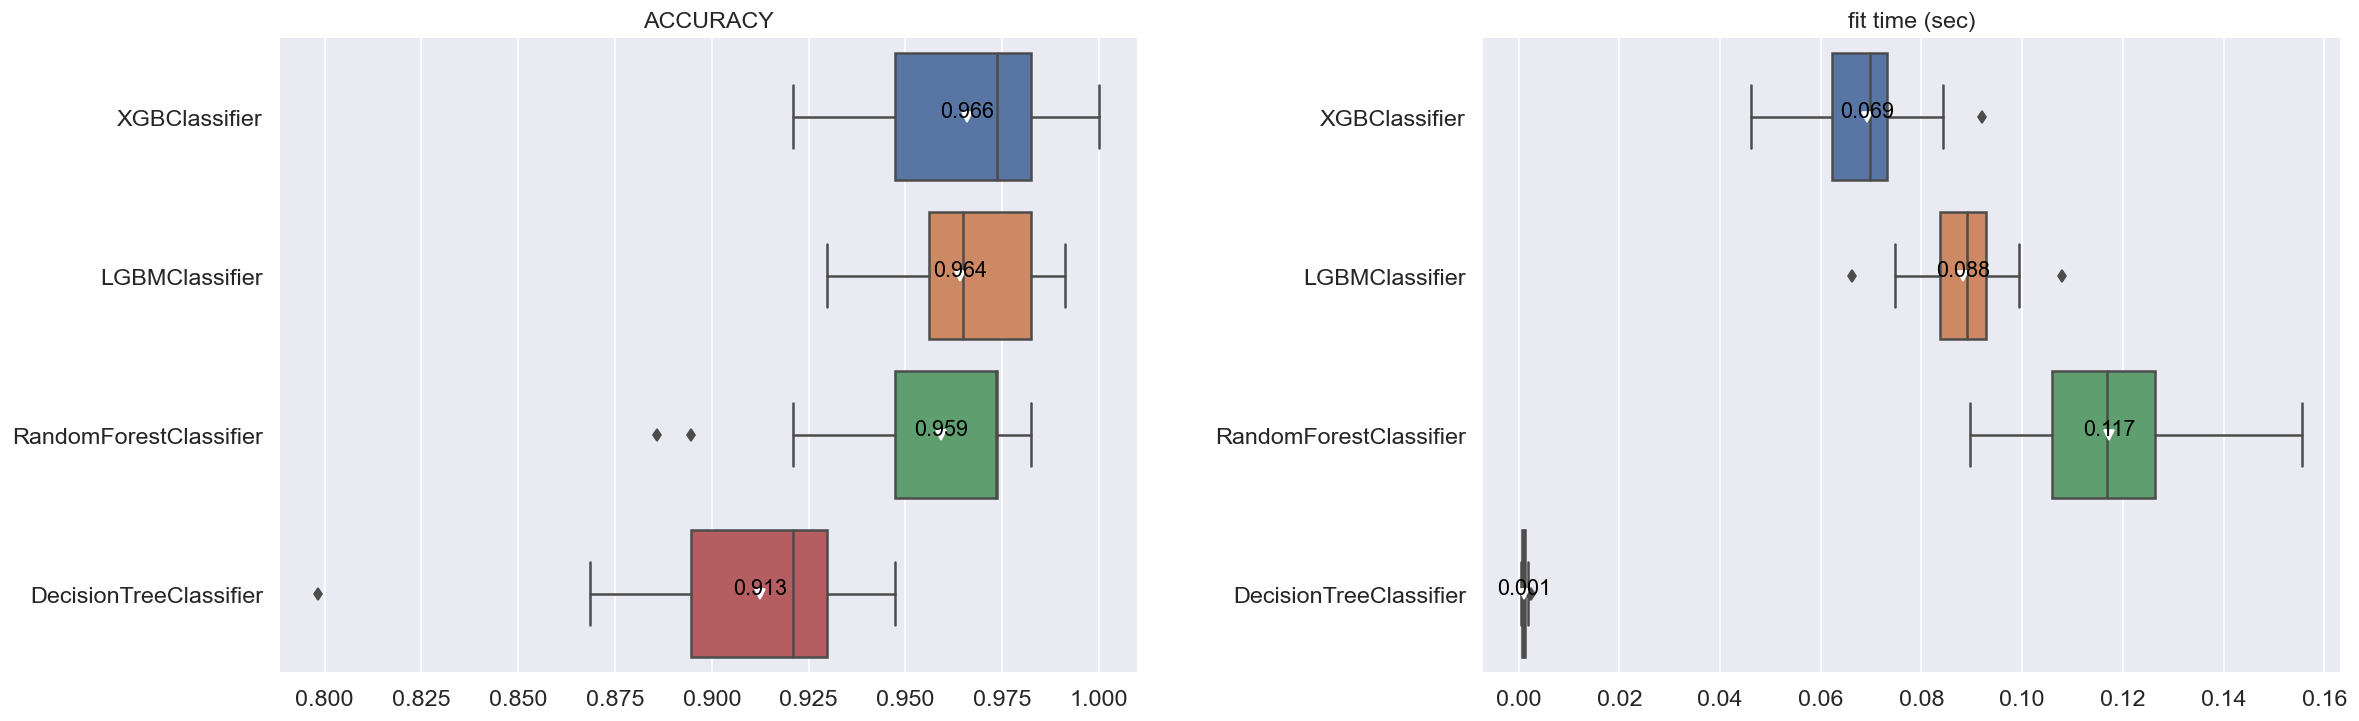

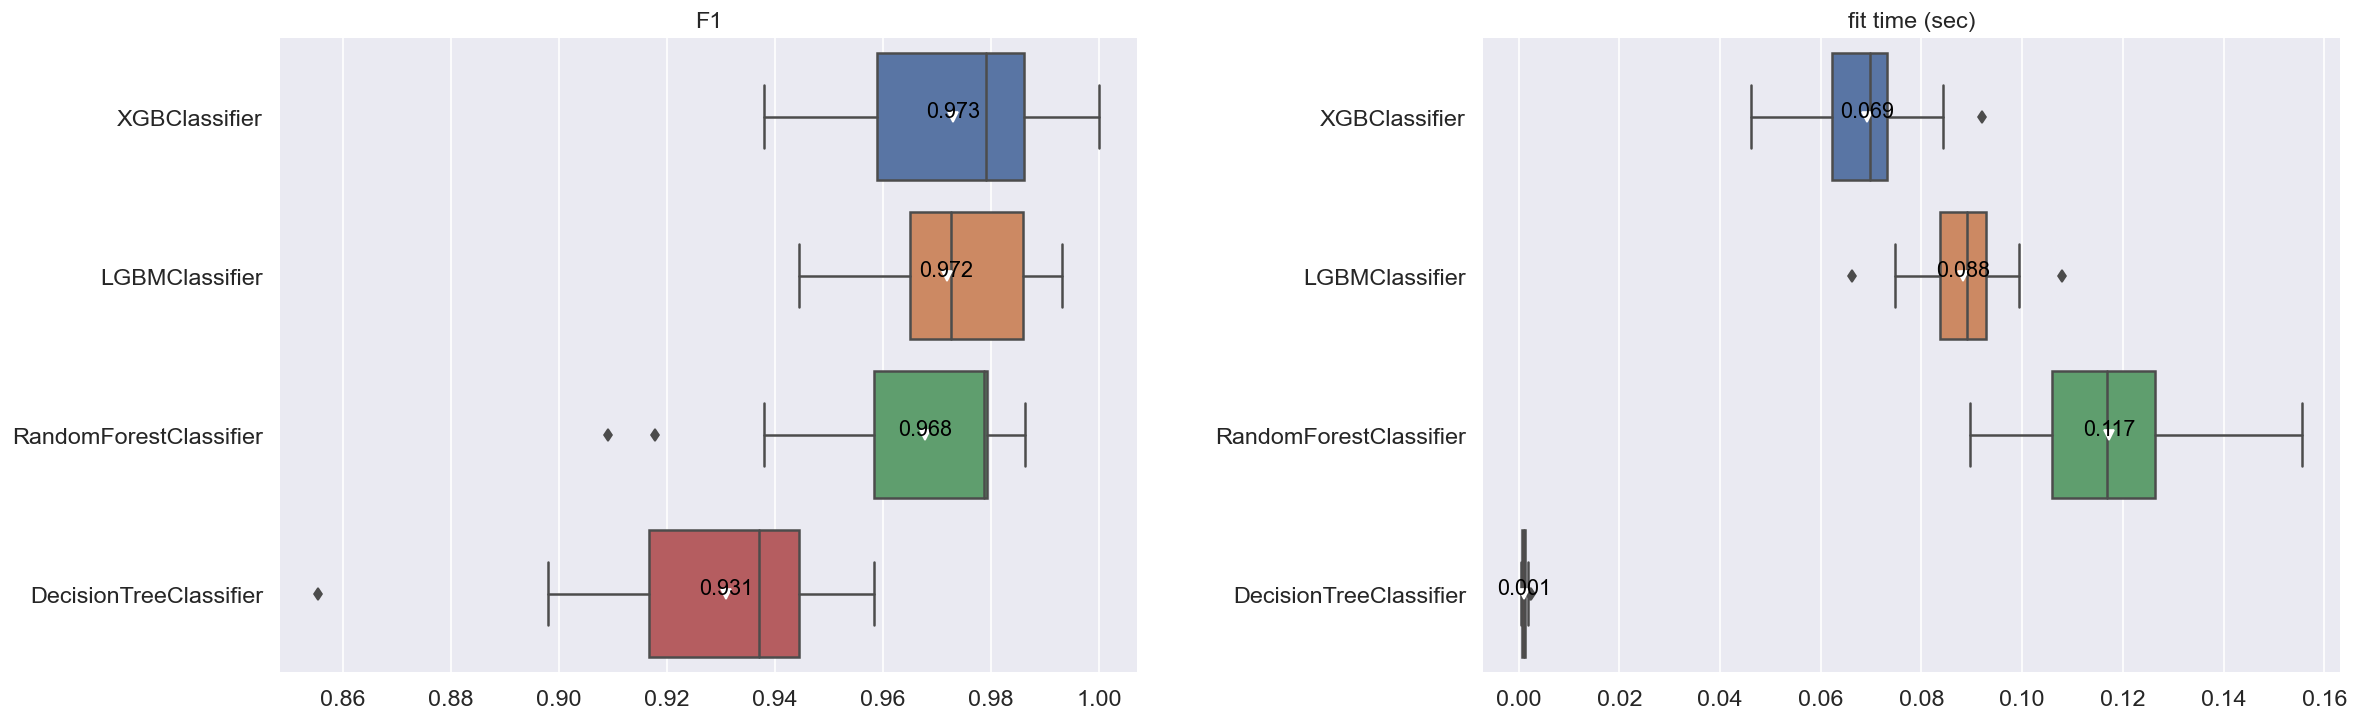

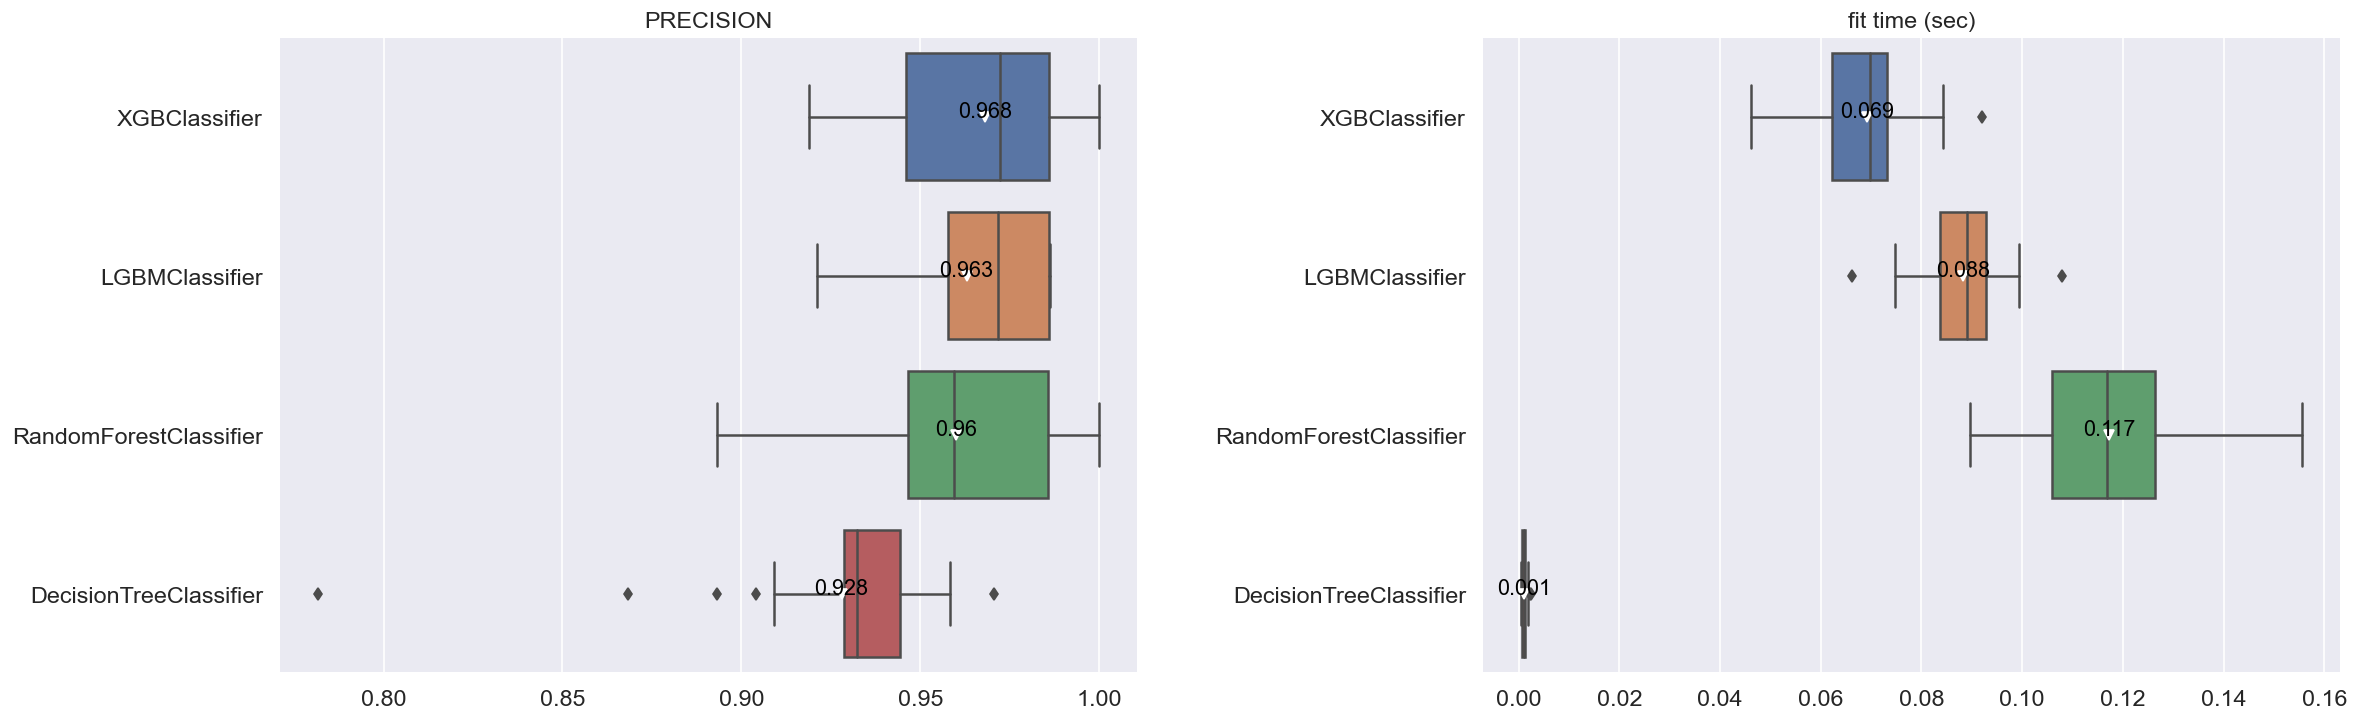

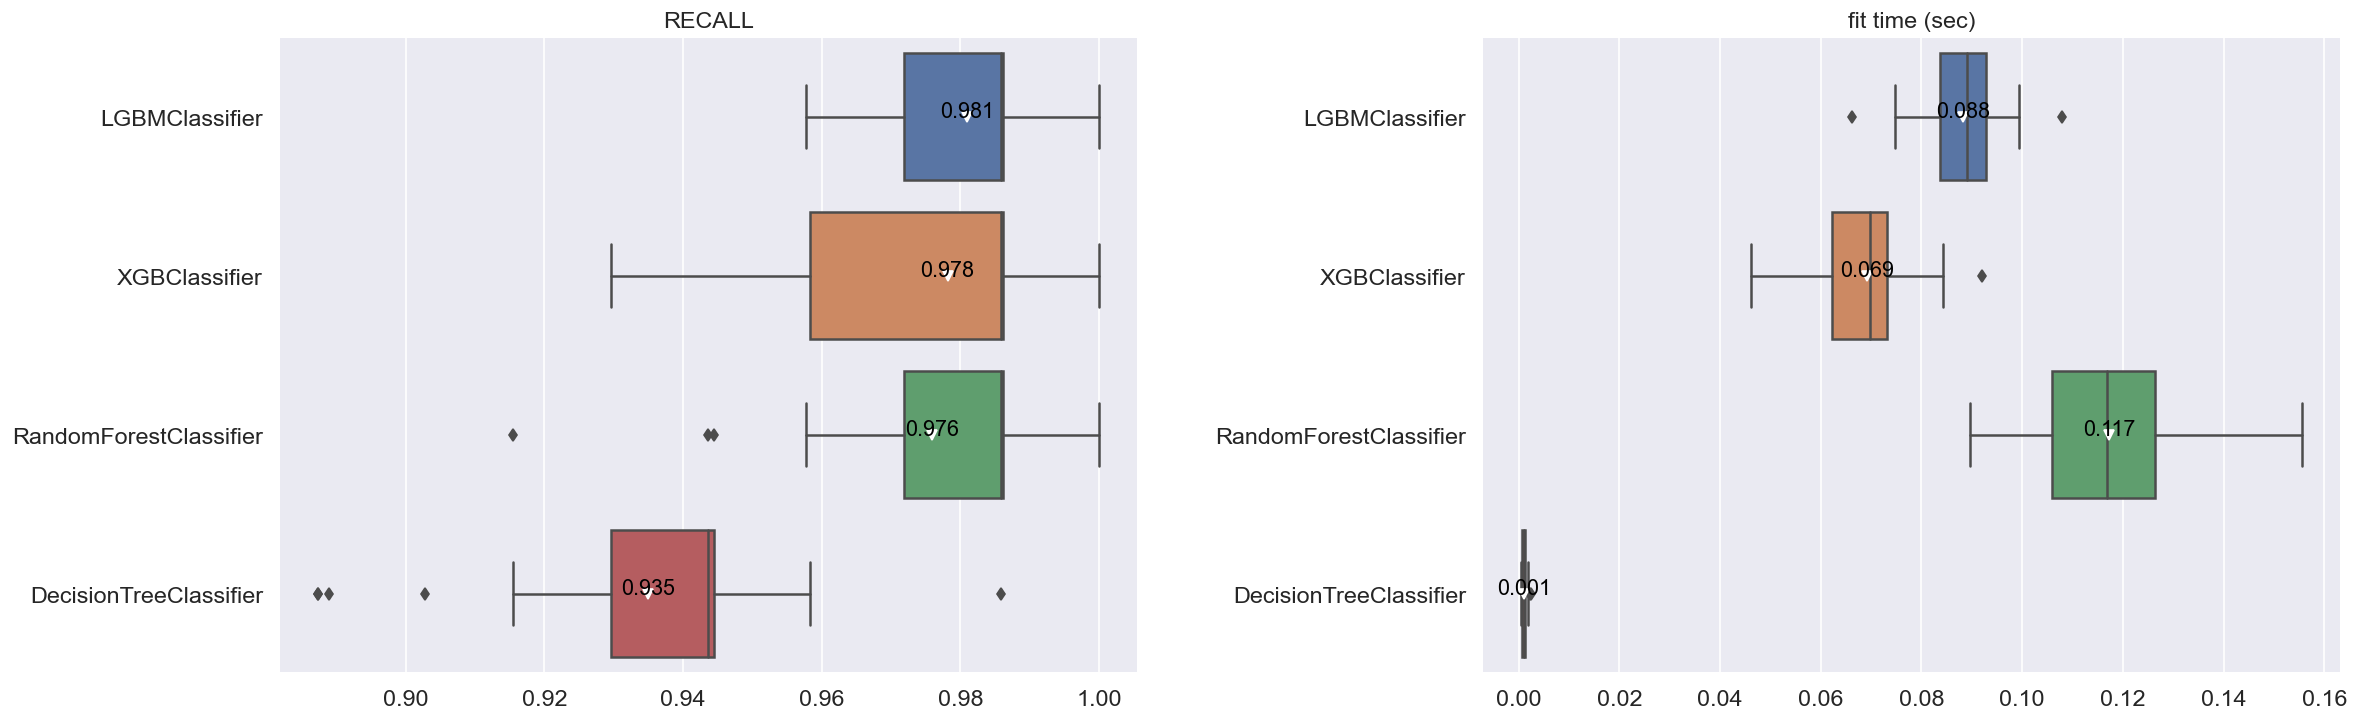

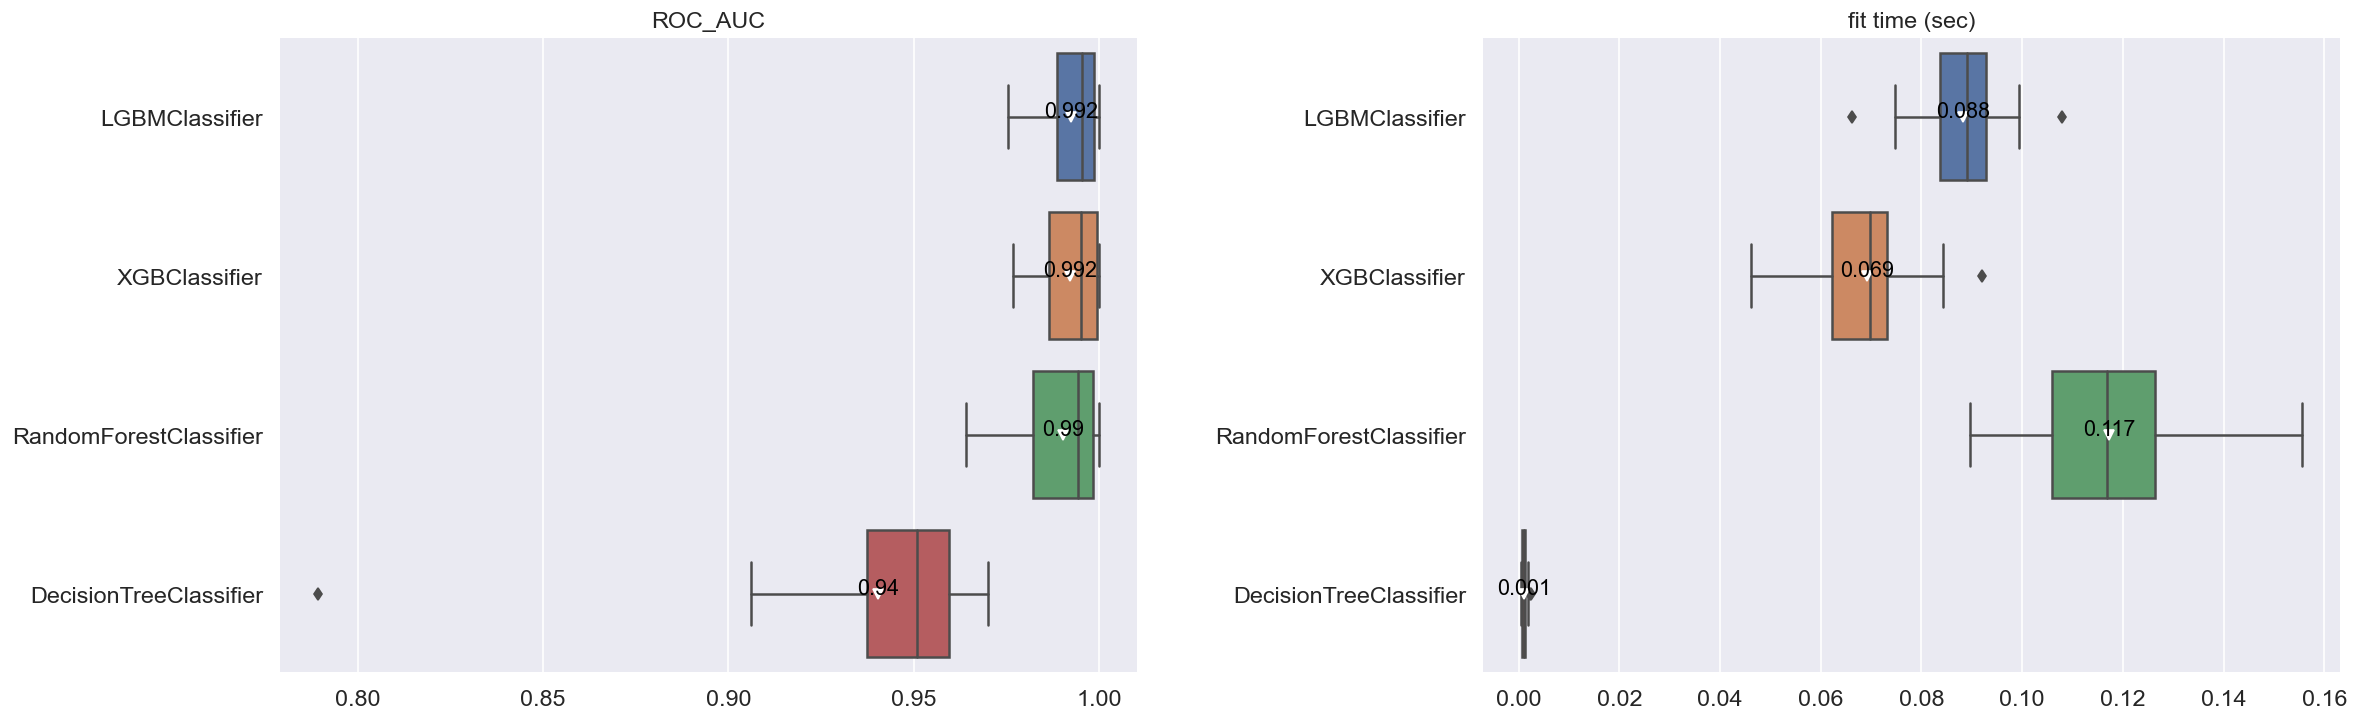

In [21]:
clf.show_cross_validation_result()

In [9]:
clf.df_cv_result

,fit_time,score_time,scoring,test_score,estimator_name
0,0.000693,0.001649,accuracy,0.894737,DecisionTreeClassifier
1,0.000678,0.001605,accuracy,0.894737,DecisionTreeClassifier
2,0.000996,0.005238,accuracy,0.947368,DecisionTreeClassifier
3,0.000648,0.001585,accuracy,0.929825,DecisionTreeClassifier
4,0.001639,0.002449,accuracy,0.938053,DecisionTreeClassifier
...,...,...,...,...,...
495,0.084194,0.002435,roc_auc,0.979037,XGBClassifier
496,0.064578,0.002445,roc_auc,0.981002,XGBClassifier
497,0.059944,0.002595,roc_auc,0.999008,XGBClassifier
498,0.061095,0.002545,roc_auc,1.000000,XGBClassifier


# Search Hyperparameters
- 교차 검증을 통해 알고리즘 후보군을 좁혔다면 해당 알고리즘별 하이퍼파라미터 튜닝을 통해 성능을 확인하는 단계로 넘어갑니다.
- 하이퍼파리미터 튜닝은 여러 방법이 있지만, 여기서는 [scikit-learn에서 제공하는 하이퍼파라미터 탐색 방법](https://scikit-learn.org/stable/modules/grid_search.html)(`GridSearchCV`, `RandomizedSearchCV`, `HalvingGridSearchCV`, `HalvingRandomSearchCV`)을 선택할 수 있도록 개발했습니다.

In [10]:
hyperparams_space = {
    "DecisionTreeClassifier": {
        "criterion": ["gini", "entropy"],
        "splitter": ["best", "random"],
        "max_depth": np.arange(5, 105, 5).astype(int),
        "min_samples_split": np.arange(2, 11).astype(int),
        "min_samples_leaf": np.arange(2, 11).astype(int),
        "max_features": ["sqrt", "log2"],
    },
    "RandomForestClassifier": {
        "n_estimators": np.linspace(100, 1000, 10).astype(int),
        "criterion": ["gini", "entropy"],
        "max_depth": np.arange(5, 105, 5).astype(int),
        "min_samples_split": np.arange(2, 11).astype(int),
        "min_samples_leaf": np.arange(2, 11).astype(int),
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False],
    },
    "XGBClassifier": {
        "n_estimators": np.linspace(100, 1000, 10).astype(int),
        "learning_rate": np.arange(0.001, 0.1, 0.01),
        "max_depth": np.arange(5, 105, 5).astype(int),
        "colsample_bytree": sp_uniform(loc=0.4, scale=0.6),
        "gamma": [i / 10.0 for i in range(3)],
        "fit_params": {"verbose": False},
        "eval_metric": ["logloss"],
        "early_stopping_rounds": [100],
    },
    "LGBMClassifier": {
        "n_estimators": np.linspace(100, 1000, 10).astype(int),
        "learning_rate": np.arange(0.001, 0.1, 0.01),
        "max_depth": np.arange(5, 105, 5).astype(int),
        "colsample_bytree": sp_uniform(loc=0.4, scale=0.6),
        "verbose": [-1],
        "fit_params": {
            "eval_metric": ["binary_logloss"],
            "callbacks": [early_stopping(100)],
        },
    },
}

In [11]:
clf.search_hyperparameter(
    X=X_train,
    y=y_train,
    feature_names=feature_names,
    search_method="random",  # 하이퍼파라미터 탐색 방법 (grid, random, grid_halving, random_halving)
    hyperparams_space=hyperparams_space,  # 알고리즘별 하이퍼파라미터 범위
    scoring="roc_auc",  # 모델 성능 지표
    kfold="RepeatedStratifiedKFold",  # Train, Test Split 방법
    n_splits=5,  # K-Fold의 K
    n_repeats=5,  # 교차 검증 반복 횟수
    #     n_iter=10,  # 파라미터 조합 수
    #     factor=3,  # 파라미터 선택 수 (`search_method`가 `*_havling`일 때만 적용)
)

 
---------------------- DecisionTreeClassifier ---------------------- 
 >>> Hyperparameter Space: 
{'criterion': ['gini', 'entropy'],
 'max_depth': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100]),
 'max_features': ['sqrt', 'log2'],
 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'splitter': ['best', 'random']}
 >>> fit_params: None
 >>> Best Parameters:
{'criterion': 'gini',
 'max_depth': 55,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'splitter': 'best'}
 >>> Finished. (elapsed_time: 0s) 
 
---------------------- LGBMClassifier ---------------------- 
 >>> Hyperparameter Space: 
{'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12fad5310>,
 'learning_rate': array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091]),
 'max_depth': array([  5,  10,  1

## Performance Metrics
- 튜닝 성능을 확인해 봅니다.

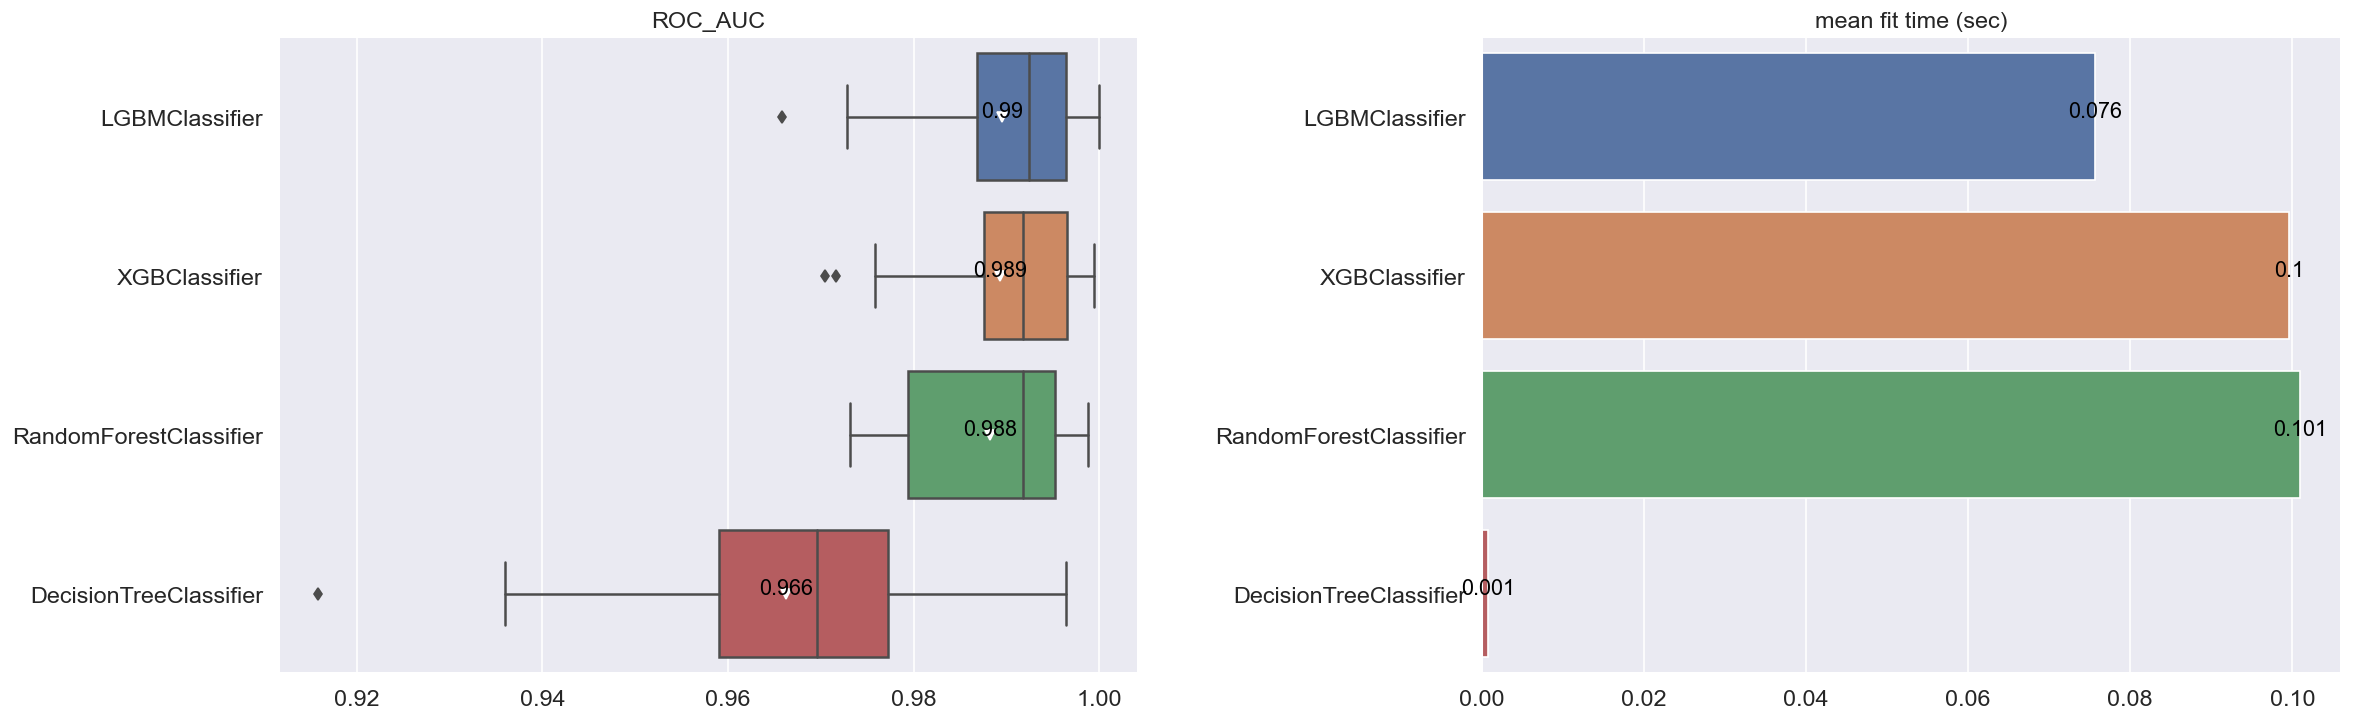

In [12]:
clf.show_hyperparameter_search_result()

# Feature Importance
- 튜닝까지 끝났으면 Feature Importances를 확인해 봅니다. 불필요 변수가 있을지, 있다면 제거를 할지 판단해야 합니다.
- 보통 이쯤되면 여러 개의 알고리즘을 계속 비교하진 않습니다. 거의 한 개의 모델로 추려지는데, 여기에서는 예시로 두 개의 알고리즘별로 Feature Importance를 각각 출력해봤습니다.

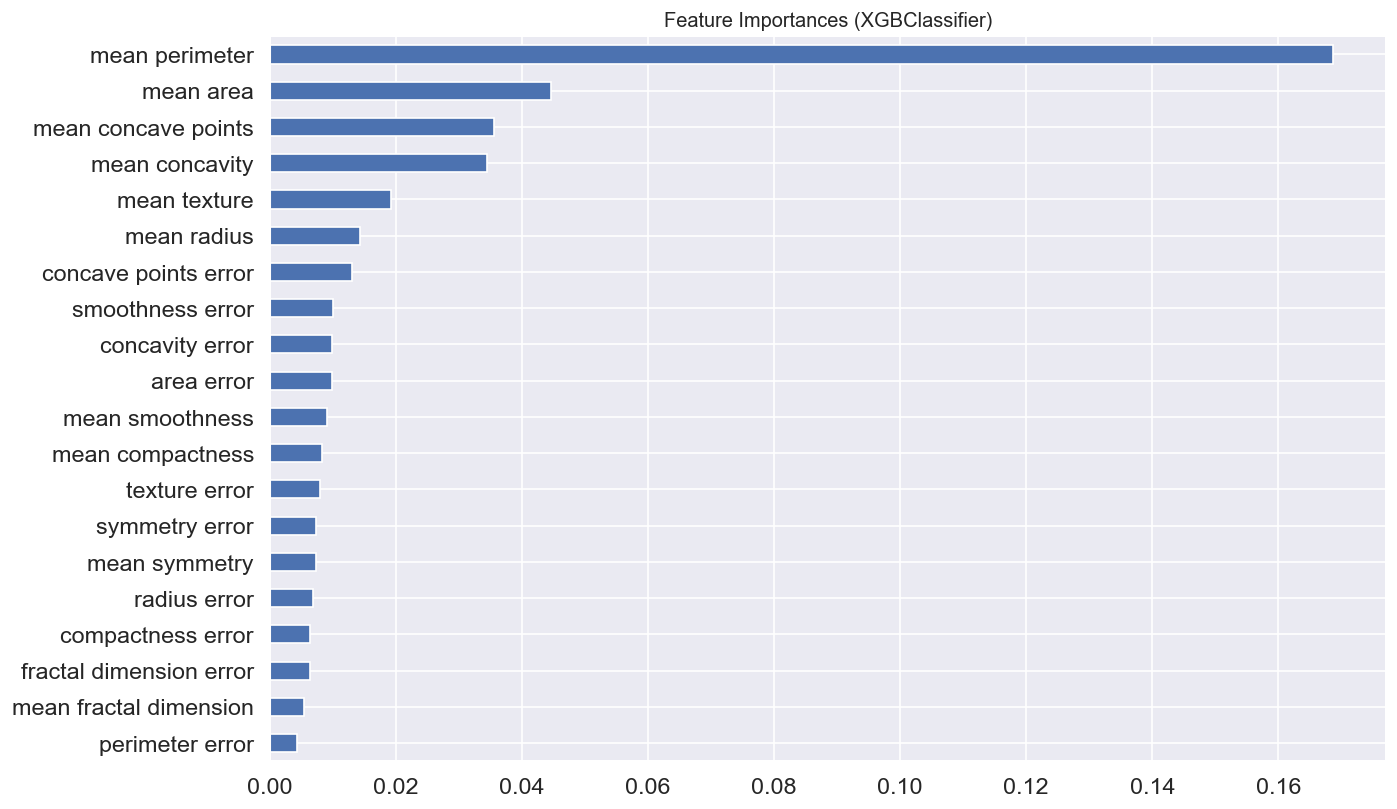

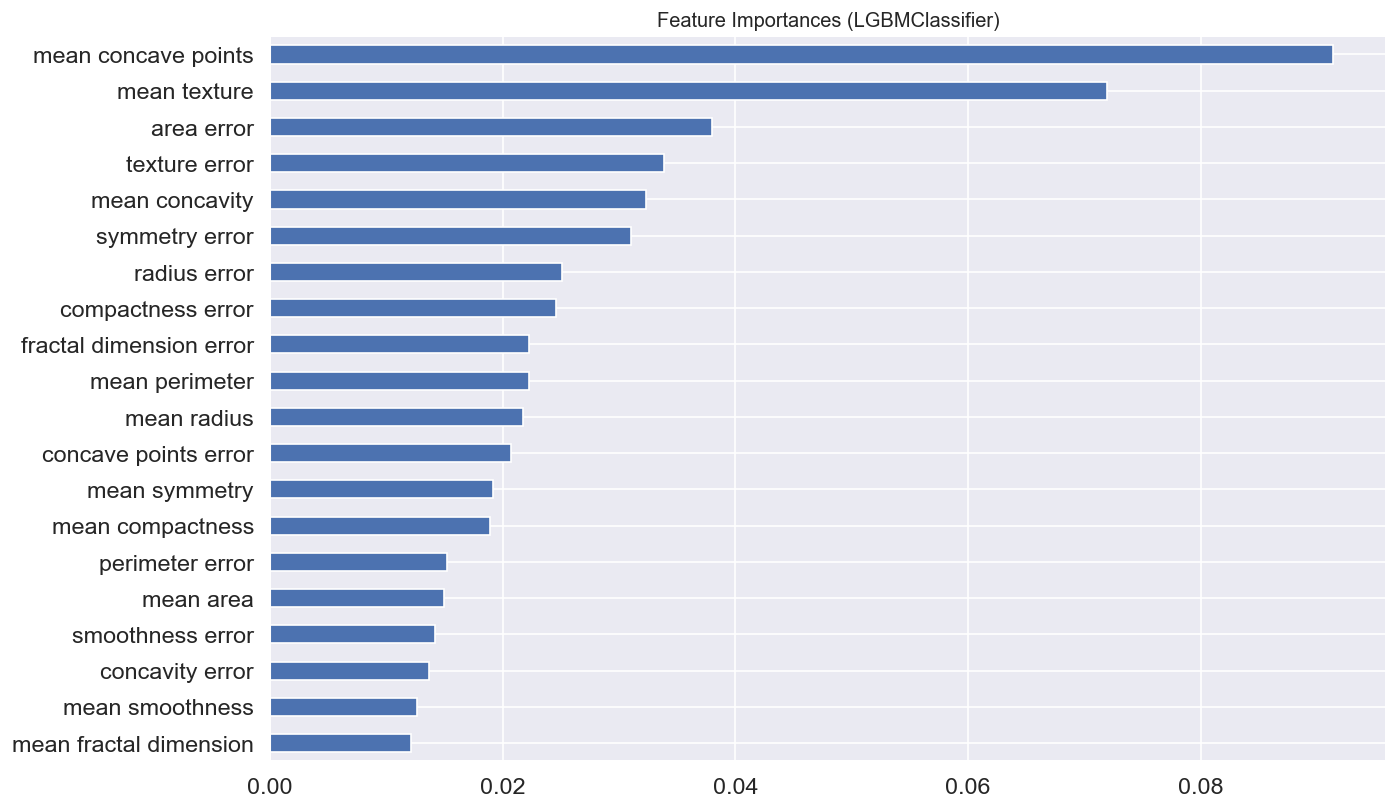

In [13]:
# 만약 `estimators`를 지정하지 않는다면 하이퍼파라미터 탐색을 실행한 모든 알고리즘의 Feature Importance가 출력됩니다.
clf.show_feature_importances(
    estimators=["XGBClassifier", "LGBMClassifier"],  # 알고리즘 선택
    n_features=20,  # 중요도가 높은 순으로 Feature 개수
)

# Permutation Importances
- 다음으로 Permutation Importance입니다. 훈련된 모델에서 특정 Feature를 사용하지 않을 때 이것이 성능 하락에 미치는 영향을 파악하는 방법으로, 모델 입장에서의 개별 Feature의 의존도를 확인하는 것입니다.
- Feature Importance까지만 보고 이것은 안 보는 경우가 종종 있는데, 오히려 이게 도움이 되는 정보라고 생각합니다. 추출 과정은 아래와 같습니다.
    1. 기존 검증 데이터셋에서 하나의 변수(Feature)를 선택하여 값의 순서를 무작위로 섞은 후 새로운 검증 데이터셋을 생성
    2. 새로운 검증 데이터셋으로 성능(score)을 측정
    3. 기존 검증 데이터셋에 의한 성능 대비 새로운 검증 데이터셋에 의한 성능 비교
       - 성능 감소 ➡ 해당 변수가 중요하다는 의미
       - 성능 큰 변화 없음 ➡ 해당 변수는 그닥 중요하진 않다는 의미


- 따라서 성능이 감소하지 않는 변수 발견 시, 해당 변수를 제와하여 다시 튜닝 수행시 두 가지 효과를 기대할 수 있습니다.
    - 성능 개선 효과
    - 변수 제거에 따른 추가 리소스 확보 가능 (특히 변수가 상당히 많을 때 유용)

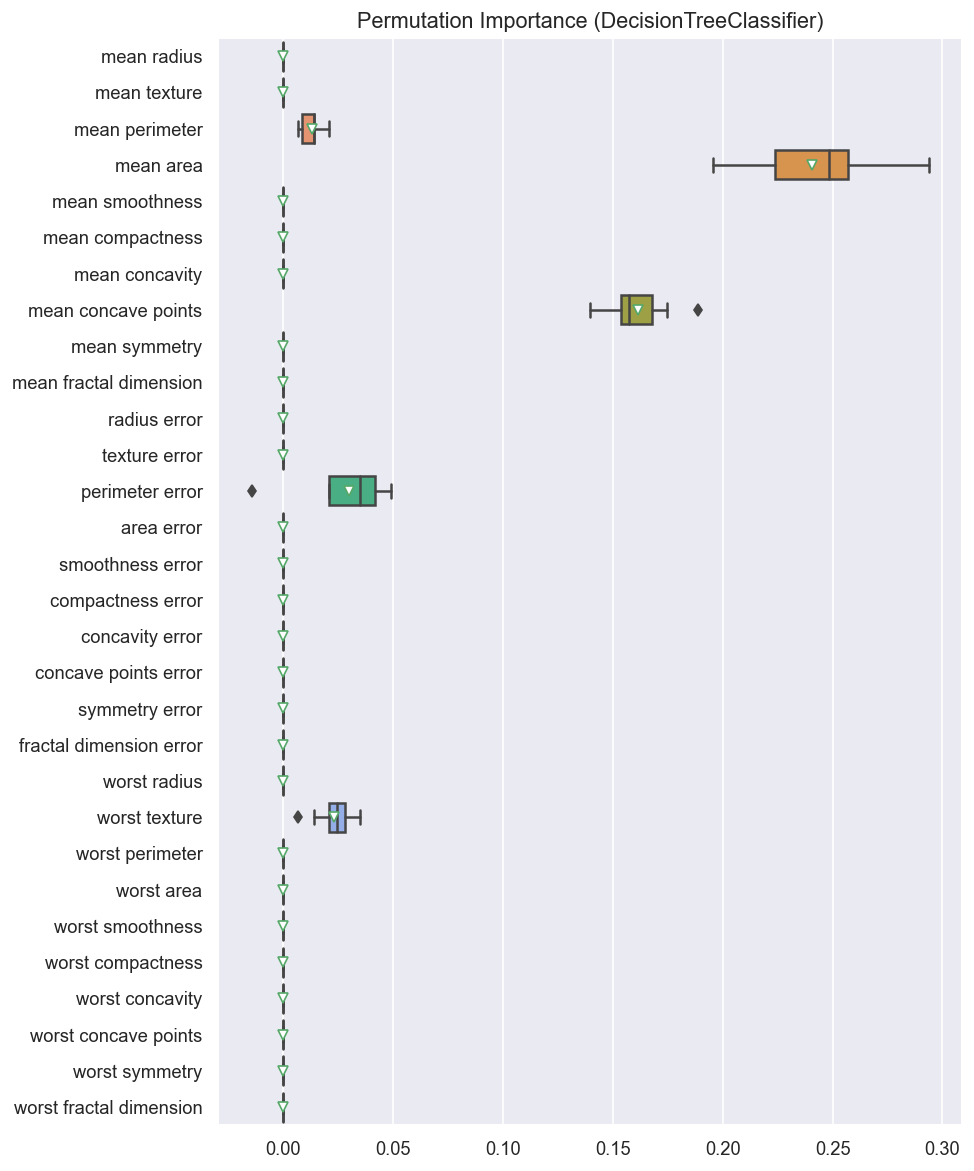

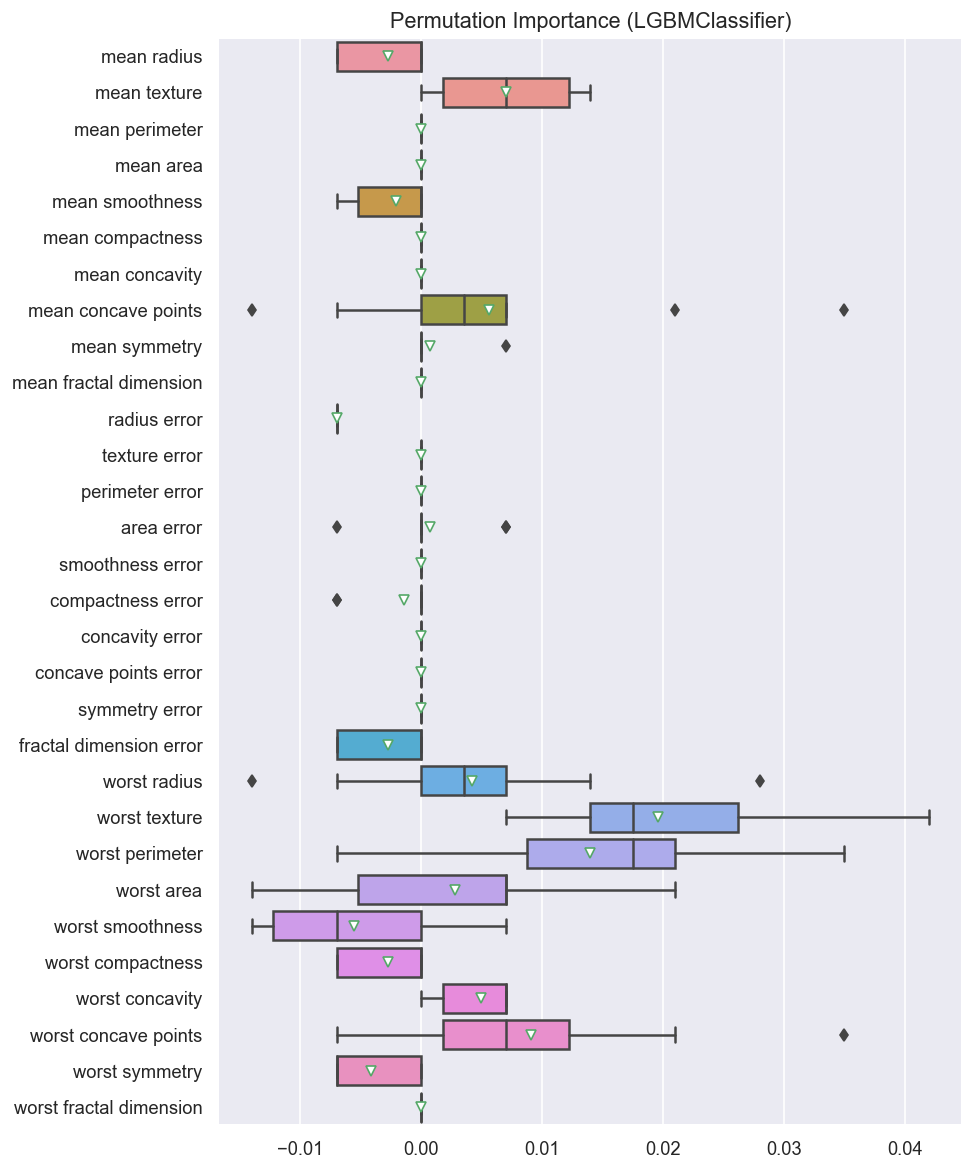

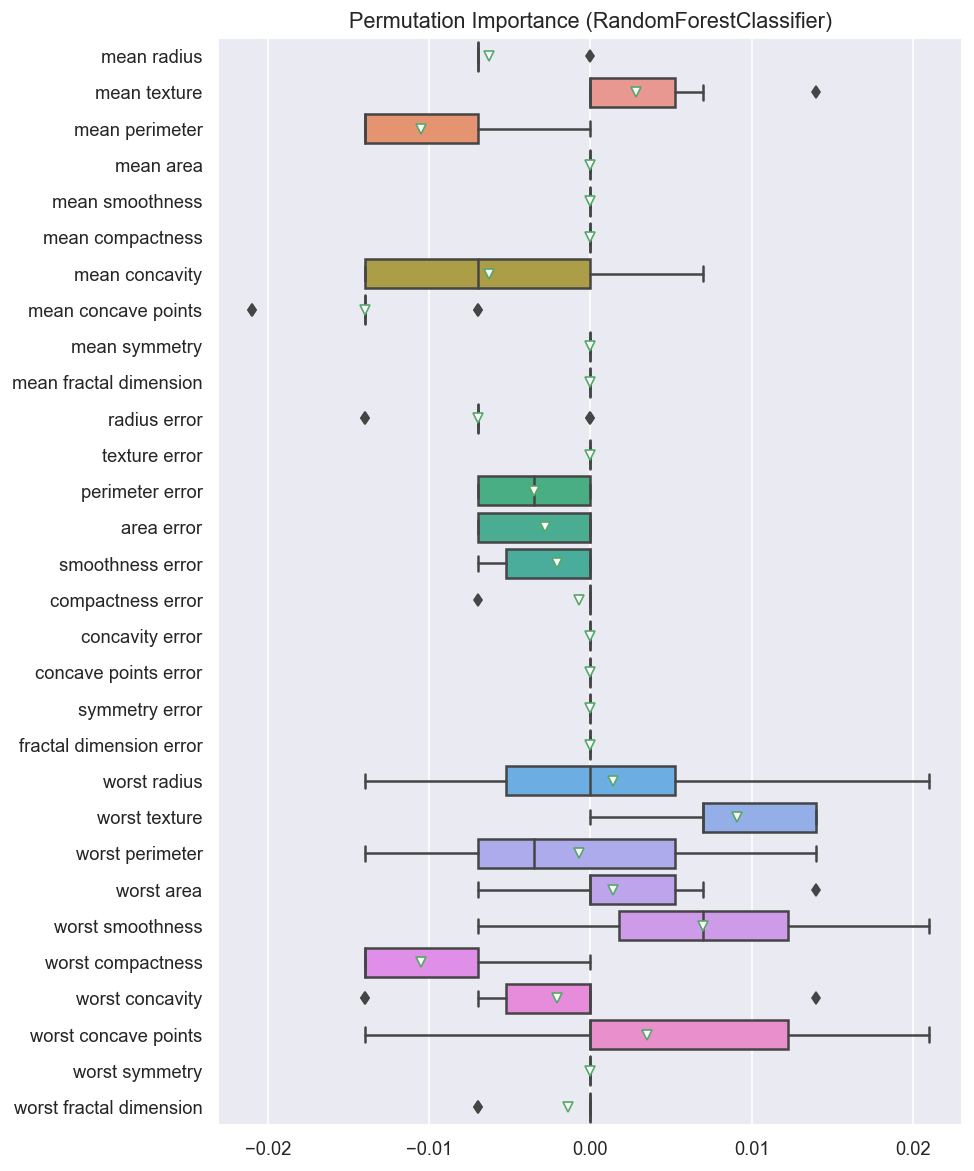

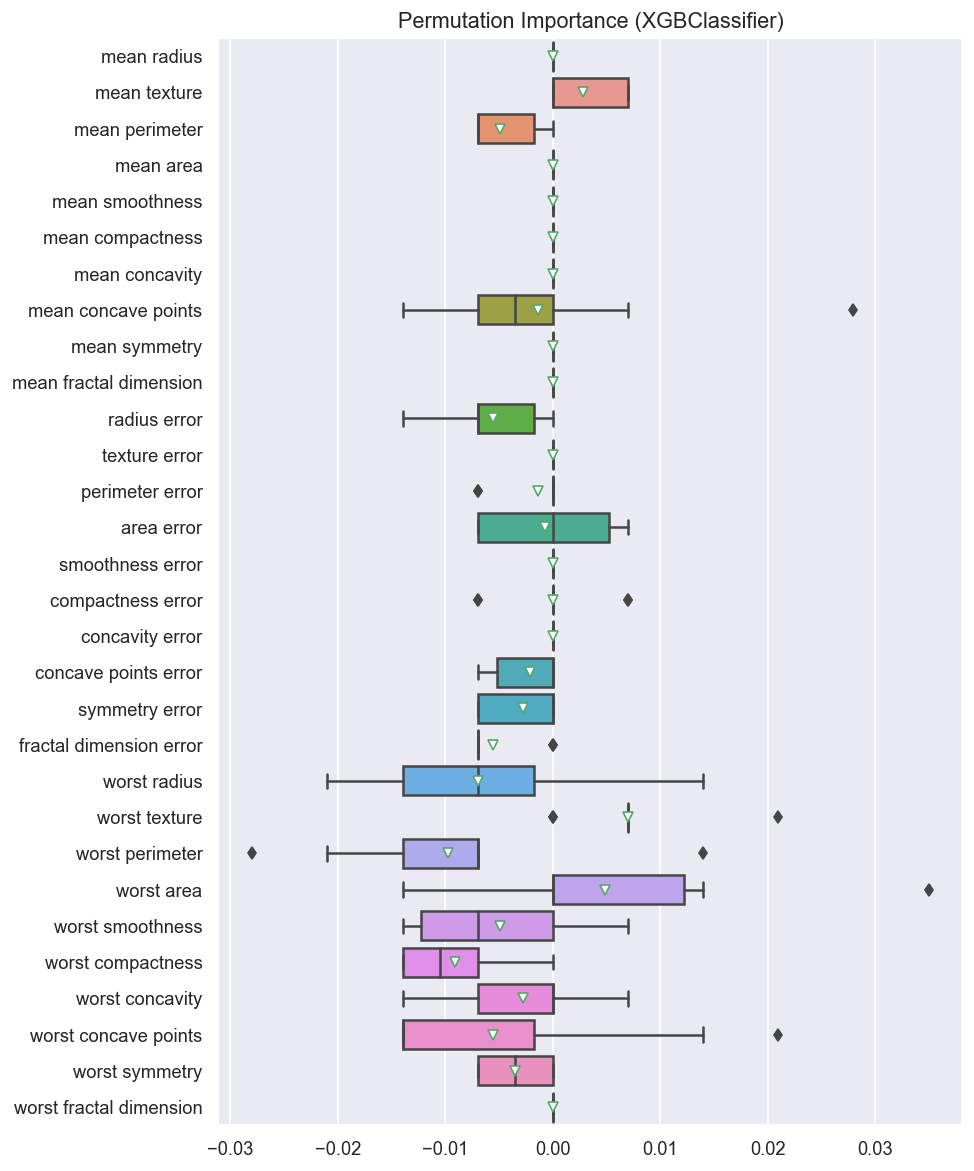

In [14]:
clf.show_permutation_importances(X=X_train, y=y_train)

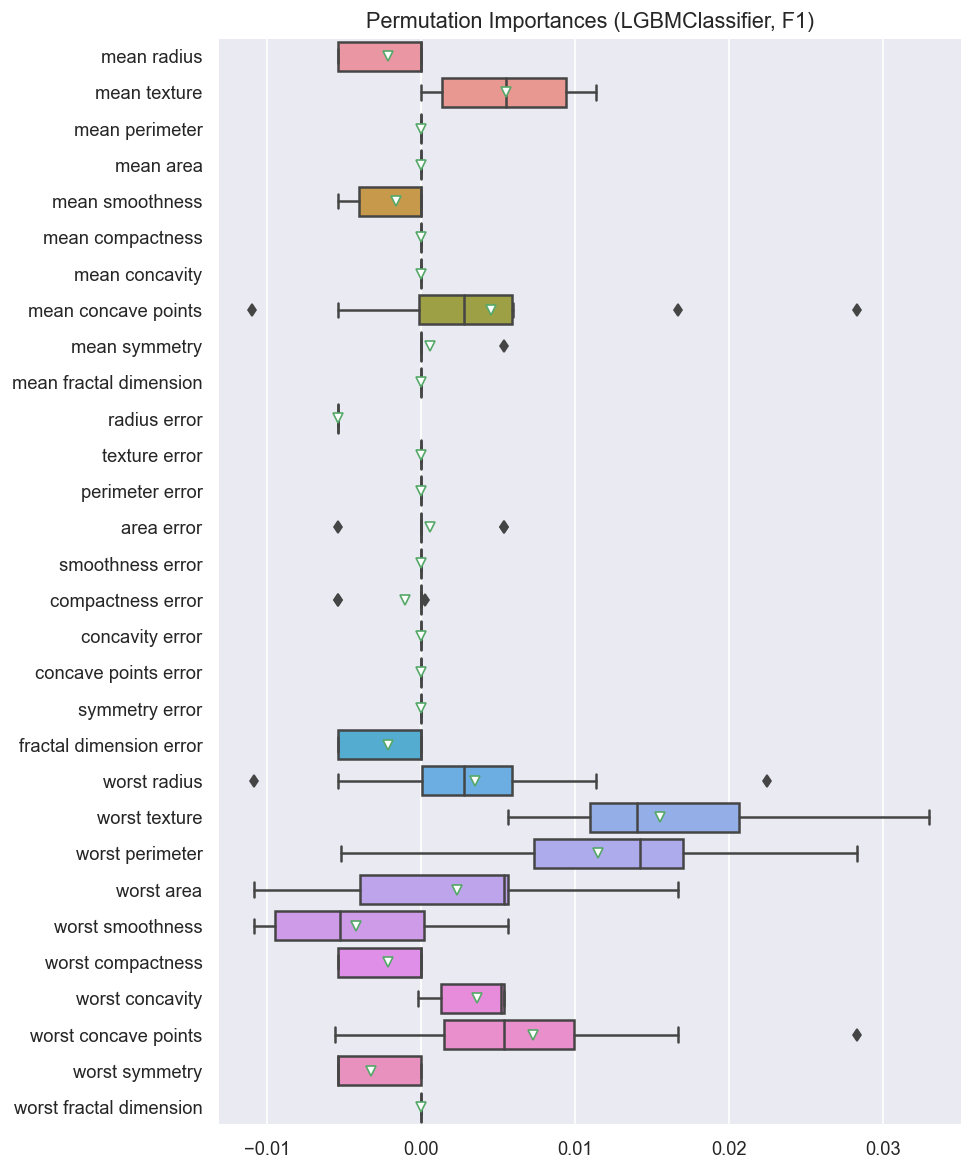

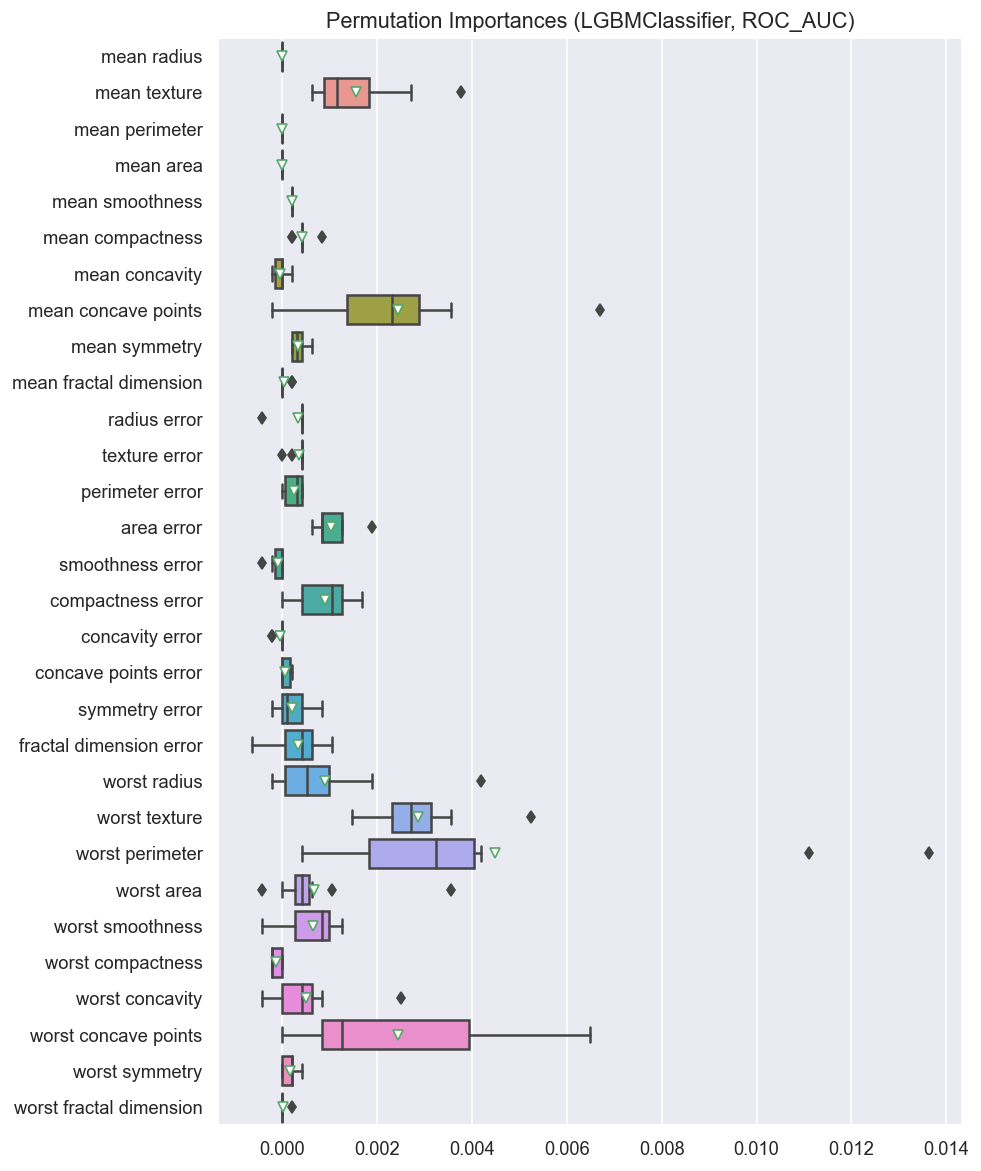

In [15]:
# 모델과 score를 따로 지정할 수도 있습니다.
clf.show_permutation_importances(
    estimators=["LGBMClassifier"], X=X_train, y=y_train, scoring=["f1", "roc_auc"]
)

#  Search Hyperparameters again
- 모델을 다시 튜닝해봅니다.
- 이미 `clf` 인스턴스가 만들어져 있으니 `search_hyperparameter()` 메서드만 재사용하시면 됩니다.
- 모델의 후보를 좁히거나, Feature를 바꾸거나, `search`, `kfold`, `n_splits` 등 파라미터 변경을 반복하여 사용할 수 있습니다.

In [16]:
hyperparams_space = {
    "DecisionTreeClassifier": {
        "criterion": ["gini", "entropy"],
        "splitter": ["best", "random"],
        "max_depth": np.arange(5, 105, 5).astype(int),
        "min_samples_split": np.arange(2, 11).astype(int),
        "min_samples_leaf": np.arange(2, 11).astype(int),
        "max_features": ["sqrt", "log2"],
    },
    "XGBClassifier": {
        "n_estimators": np.linspace(100, 1000, 10).astype(int),
        "learning_rate": np.arange(0.001, 0.1, 0.01),
        "max_depth": np.arange(5, 105, 5).astype(int),
        "colsample_bytree": sp_uniform(loc=0.4, scale=0.6),
        "gamma": [i / 10.0 for i in range(3)],
        "fit_params": {"verbose": False},
        "eval_metric": ["logloss"],
        "early_stopping_rounds": [100],
    },
    "LGBMClassifier": {
        "n_estimators": np.linspace(100, 1000, 10).astype(int),
        "learning_rate": np.arange(0.001, 0.1, 0.01),
        "max_depth": np.arange(5, 105, 5).astype(int),
        "colsample_bytree": sp_uniform(loc=0.4, scale=0.6),
        "verbose": [-1],
        "fit_params": {
            "eval_metric": ["binary_logloss"],
            "callbacks": [early_stopping(100)],
        },
    },
}

clf.search_hyperparameter(
    X=X_train,
    y=y_train,
    feature_names=feature_names,
    search_method="random",
    hyperparams_space=hyperparams_space,
    kfold="StratifiedKFold",
    scoring="roc_auc",
    n_splits=10,
)

 
---------------------- DecisionTreeClassifier ---------------------- 
 >>> Hyperparameter Space: 
{'criterion': ['gini', 'entropy'],
 'max_depth': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100]),
 'max_features': ['sqrt', 'log2'],
 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'splitter': ['best', 'random']}
 >>> fit_params: None
 >>> Best Parameters:
{'criterion': 'gini',
 'max_depth': 45,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 9,
 'splitter': 'best'}
 >>> Finished. (elapsed_time: 0s) 
 
---------------------- LGBMClassifier ---------------------- 
 >>> Hyperparameter Space: 
{'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12f84f820>,
 'learning_rate': array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091]),
 'max_depth': array([  5,  10,  15

# Best Model
- 최종 모델을 확인해 봅니다. 이 코드를 실행하는 경로 내의 `model_savled` 폴더에 `.joblib` 파일로 생성되어 있습니다.

In [17]:
clf.get_best_model_info()

{'mean_test_score': 0.9890206552706553,
 'std_test_score': 0.015052353843935834,
 'mean_fit_time': 0.09041767120361328,
 'estimator_name': 'LGBMClassifier',
 'params': {'colsample_bytree': 0.8328048278951872,
  'learning_rate': 0.09099999999999998,
  'max_depth': 80,
  'n_estimators': 300,
  'objective': 'binary',
  'verbose': -1}}

In [18]:
# 최종 선택된 모델로 다시 예측해 봅니다.
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

best_model = clf.get_best_classifier()
pred = best_model.predict(X_train_scaled)

print(accuracy_score(y_train, pred))

0.9929701230228472


# Load Model
- 로컬에 저장되어 있던 모델을 로드하여 실제 데이터로 다시 예측을 해봅니다. (`LGBMClassifier`이 저장된 것으로 가정)
- 이렇게 모델을 주기적으로 업데이트하여 저장해놓고, 업데이트된 모델을 실 예측에 사용하는 파이프라인 배치를 만들면 됩니다.

In [19]:
model = load("model_saved/LGBMClassifier.joblib")
pred = model.predict(X=X_train_scaled)

print(accuracy_score(y_train, pred))

0.9929701230228472


# Decision Tree
- (Appendix) `Decision Tree`를 튜닝한 경우, 트리 구조를 시각화해봅니다.

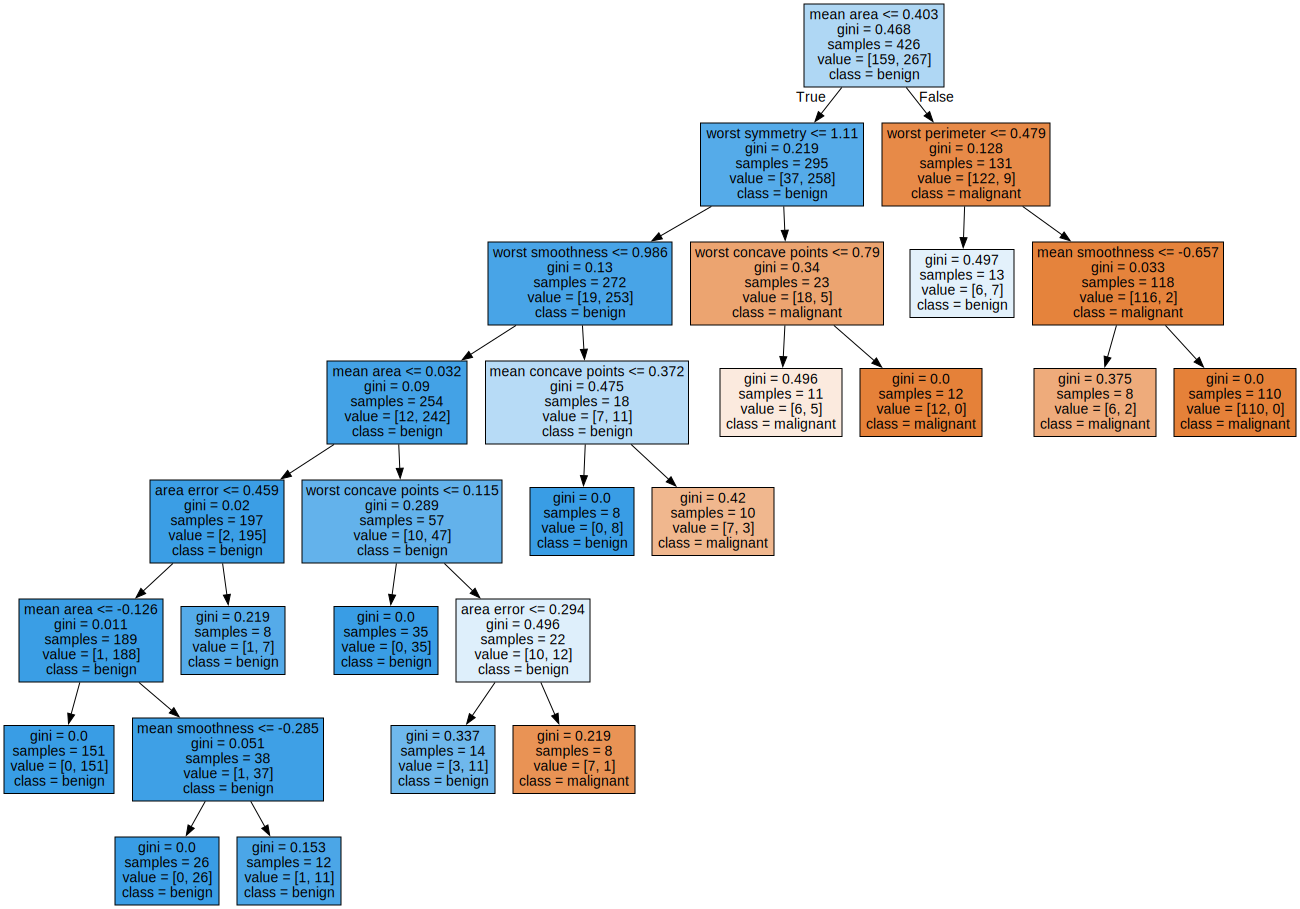

In [20]:
clf.show_decision_tree(
    feature_names=feature_names, class_names=breast_cancer.target_names
)